In [6]:
""" importing datasets"""
import nltk
nltk.download('gutenberg')

from nltk.corpus import gutenberg
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
# Load the dataset
data = gutenberg.raw('shakespeare-hamlet.txt')

# Save to file
with open("hamlet.txt", "w", encoding="utf-8") as file:
    file.write(data)

# Split text into lines
lines = data.splitlines()

print("----- FIRST 10 LINES -----")
for line in lines[:20]:
    print(line)

print("\n----- LAST 10 LINES -----")
for line in lines[-20:]:
    print(line)


----- FIRST 10 LINES -----
[The Tragedie of Hamlet by William Shakespeare 1599]


Actus Primus. Scoena Prima.

Enter Barnardo and Francisco two Centinels.

  Barnardo. Who's there?
  Fran. Nay answer me: Stand & vnfold
your selfe

   Bar. Long liue the King

   Fran. Barnardo?
  Bar. He

   Fran. You come most carefully vpon your houre

   Bar. 'Tis now strook twelue, get thee to bed Francisco


----- LAST 10 LINES -----
Euen whiles mens mindes are wilde,
Lest more mischance
On plots, and errors happen

   For. Let foure Captaines
Beare Hamlet like a Soldier to the Stage,
For he was likely, had he beene put on
To haue prou'd most royally:
And for his passage,
The Souldiours Musicke, and the rites of Warre
Speake lowdly for him.
Take vp the body; Such a sight as this
Becomes the Field, but heere shewes much amis.
Go, bid the Souldiers shoote.

Exeunt. Marching: after the which, a Peale of Ordenance are shot
off.


FINIS. The tragedie of HAMLET, Prince of Denmarke.


[nltk_data] Downloading package gutenberg to /usr/share/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [7]:
with open('hamlet.txt', 'r') as file:
    text = file.read().lower()

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1
print(f"Total Words: {total_words}")

# Generate input sequences

Total Words: 4818


In [8]:
input_sequences = []
for line in text.split('\n'):
    if line.strip():  # Ignore empty lines
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

In [9]:
max_sequence_len = max(len(x) for x in input_sequences)
print(f"Max Sequence Length: {max_sequence_len}")
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')
X, y = input_sequences[:, :-1], input_sequences[:, -1]  # Fix slicing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=total_words)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=total_words)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

Max Sequence Length: 14
X_train shape: (20585, 13), y_train shape: (20585, 4818)


In [10]:
X

array([[   0,    0,    0, ...,    0,    0,    1],
       [   0,    0,    0, ...,    0,    1,  687],
       [   0,    0,    0, ...,    1,  687,    4],
       ...,
       [   0,    0,    0, ...,  687,    4,   45],
       [   0,    0,    0, ...,    4,   45, 1047],
       [   0,    0,    0, ...,   45, 1047,    4]], dtype=int32)

In [16]:
y

array([ 687,    4,   45, ..., 1047,    4,  193], dtype=int32)

In [17]:
# Define the model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len - 1))
model.add(tf.keras.layers.LSTM(150, return_sequences=False))
model.add(tf.keras.layers.Dense(150, activation='relu'))
model.add(tf.keras.layers.Dense(total_words, activation='softmax'))
model.build(input_shape=(None, max_sequence_len - 1))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=120, batch_size=64, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1768313399.946293      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 13, 100)        │       481,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 150)            │       150,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4818)           │       727,518 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,382,568 (5.27 MB)

 Trainable params: 1,382,568 (5.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/120


I0000 00:00:1768313404.905310     126 cuda_dnn.cc:529] Loaded cuDNN version 90300


322/322 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.0282 - loss: 7.1982 - val_accuracy: 0.0336 - val_loss: 6.6374
Epoch 2/120
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0369 - loss: 6.4299 - val_accuracy: 0.0490 - val_loss: 6.6615
Epoch 3/120
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0516 - loss: 6.2509 - val_accuracy: 0.0482 - val_loss: 6.7284
Epoch 4/120
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0507 - loss: 6.0819 - val_accuracy: 0.0517 - val_loss: 6.8571
Epoch 5/120
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0558 - loss: 5.9435 - val_accuracy: 0.0567 - val_loss: 6.9119
Epoch 6/120
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0642 - loss: 5.7787 - val_accuracy: 0.0670 - val_loss: 6.9773
Epoch 7/120
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0750 - loss: 5.6363 - val_accuracy: 0.0688 - val_loss: 7.1195
Epoch 8/120
322/322 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0868 - loss: 5.4648 - val_accuracy: 0.069

In [18]:
# Function to predict the next word
def predict_next_word(model, tokenizer, text, max_sequence_len):
    token_list = tokenizer.texts_to_sequences([text])[0]
    if len(token_list) >= max_sequence_len:
        token_list = token_list[-(max_sequence_len-1):]  # Ensure the sequence length matches
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    predicted_word_index = np.argmax(predicted, axis=1)
    for word, index in tokenizer.word_index.items():
        if index == predicted_word_index:
            return word
    return None

In [19]:
input_text="who"
print(f"input text:{input_text}")
max_sequence_len=model.input_shape[1]+1
next_word=predict_next_word(model,tokenizer,input_text,max_sequence_len)
print(f"next word predection:{next_word}")

input text:who
next word predection:was


In [20]:
model.save("next_word_lstm.h5")
import pickle
with open('tokenizer.pickle','wb') as handle:
    with open ('tokenizer.pickle','wb') as handle:
        pickle.dump(tokenizer,handle,protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
""" more texts """
input_text="after"
print(f"input text:{input_text}")
max_sequence_len=model.input_shape[1]+1
next_word=predict_next_word(model,tokenizer,input_text,max_sequence_len)
print(f"next word predection:{next_word}")


input text:after
next word predection:his


In [30]:
""" more texts """
input_text="he will go"
print(f"input text:{input_text}")
max_sequence_len=model.input_shape[1]+1
next_word=predict_next_word(model,tokenizer,input_text,max_sequence_len)
print(f"next word predection:{next_word}")


input text:he will go
next word predection:about


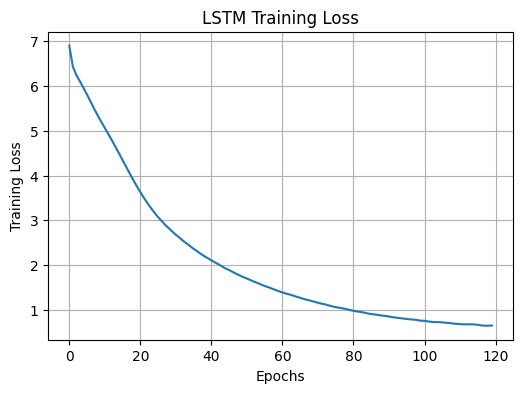

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("LSTM Training Loss")
plt.grid(True)
plt.show()
